##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# FGSM을 이용한 적대적 샘플 생성

이 예제는 FGSM생성 첫번째 단계인 descent와 반대방향의 노이즈를 생성하는 예제입니다.

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
#matplot 설정
mpl.rcParams['figure.figsize'] = (8, 8) 
mpl.rcParams['axes.grid'] = False

훈련된 모델을 불러옵니다.

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True)
pretrained_model.trainable = False

# ImageNet labels
# 결과에 따라 class이름, class description, 점수를 출력한다.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 2s 0us/step


**preprocess()**<br>
MobileNetV2 모델에 맞추어 입력이미지의 크기를 resize합니다.<br>
참고: MobileNetV2의 입력shape은 (224,224,3) 입니다.<br><br>

**get_imagent_label()**<br>
모델이 결과를 출력하면 그 확률벡터로부터 labels를 추출합니다.
이미지 1280개에 대한 확률로 예측하지만, 확률이 제일 높은 상위 1개의 결과를 가져옵니다.

In [4]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...] #batch_size, width, height, channel
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## 원본 이미지


In [5]:
path="/content"
#train셋 다운받기
tf.keras.utils.get_file(path+'/testcat.jpg','https://docs.google.com/uc?export=download&id=1oTBz-oEQ0XYf7evpFRNZAHHO_EsA-l2b&confirm=t')


29639/29639 [==============================] - 0s 0us/step


'/content/testcat.jpg'

In [6]:
img=tf.io.read_file('/content/testcat.jpg')
img=tf.image.decode_image(img)

In [7]:
image = preprocess(img)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 9s 9s/step


이미지 살펴보기

35363/35363 [==============================] - 0s 0us/step


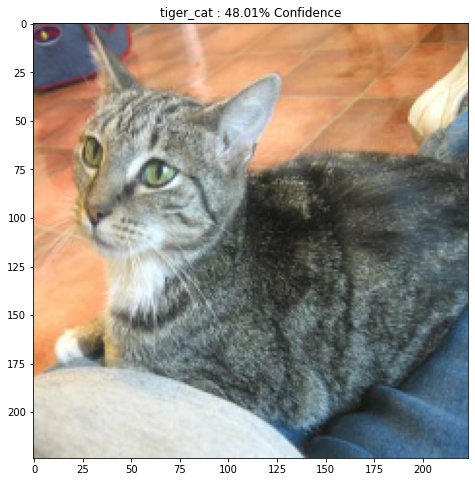

In [8]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## 적대적 이미지 생성하기

### FGSM 실행하기

첫번째 단계는 샘플 생성을 위해 원본 이미지에 가하게 될 왜곡을 생성하는 것입니다. 앞서 살펴보았듯이, 왜곡을 생성할 때에는 입력 이미지에 대한 그래디언트를 사용합니다.

In [9]:
#원본코드

loss_object = tf.keras.losses.CategoricalCrossentropy()

def img_descent(image, label):
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = pretrained_model(image)
    loss = loss_object(label, prediction)

  gradient = tape.gradient(loss, image)
  # sign()으로 부호 반대로
  signed_grad = tf.sign(gradient)
  return signed_grad

생성한 왜곡을 시각화해 볼 수 있습니다.

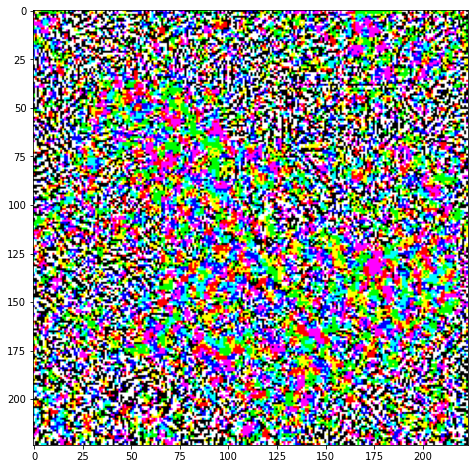

In [10]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = img_descent(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

엡실론을 바꿔가며 다양한 값들을 시도<br>
엡실론이 0.2인 경우 peacock(공작)이라고 인식.

In [11]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 42ms/step


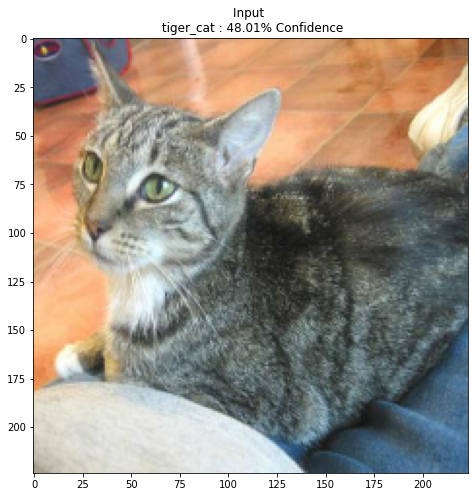

1/1 [==============================] - 0s 35ms/step


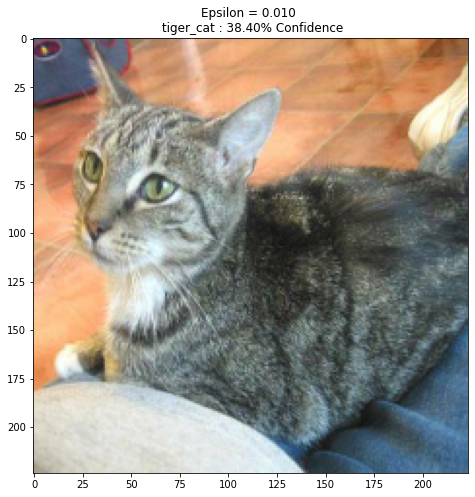

1/1 [==============================] - 0s 37ms/step


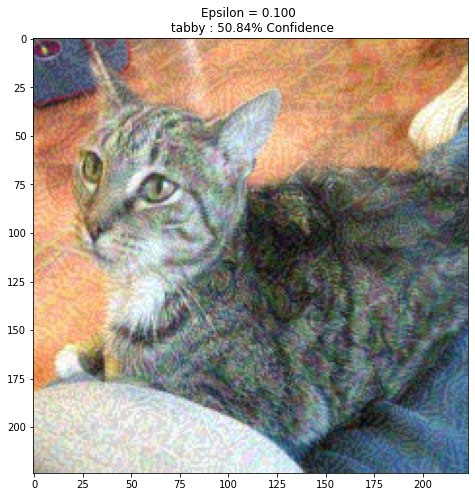

1/1 [==============================] - 0s 44ms/step


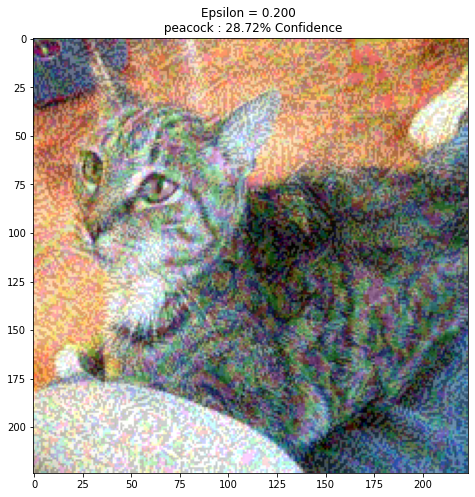

In [13]:
epsilons = [0, 0.01, 0.1, 0.2]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])